# How dose the land surface affect the urban cliamte?
Junjie Yu, 2023-12-06, Manchester, UK

ENV: RL_urban; docker container: clmu; docker image: clmu-app:1 

## 1 Get the shell script for running CESM/CLM

simulation location : New York City

New York City coordinates can be replaced with other city coordinates

40°42′46″N 74°00′22″W from https://en.wikipedia.org/wiki/New_York_City

New York City = {'lat': 40.42, 'lon': -74.00}

initialize

In [ ]:
from utils.cesm import *



# the path of the case script, in clmu-app, clm5.0 was installed in /p/project/clm5.0
CASESCRIPT = "/p/project/clm5.0/cime/scripts"

# the path of the case script, in local machine
# we use the (--mount type=bind,source="$(pwd)"/p,target=/p) to mount the local directory to the docker container
# We has the forcing data in local machine, so we want to mount the forcing directory to the container
# note that bind the has some constraints, e.g., file fverwriting, file permissions, etc., so we need to be careful
CASESCRIPT_local = "/home/zhonghua/p/project/clm5.0/cime/scripts"

# the path of the case root, in clmu-app, the case root is in /p/scratch/CESMDATAROOT/CaseOutputs
CASEROOT_local = "/home/zhonghua/p/scratch/CESMDATAROOT/CaseOutputs"

# the path of the case root, in local machine
DOUT_S_ROOT = "/home/zhonghua/p/scratch/CESMDATAROOT/Archive"


# the path of the script
# Here, we provide the script that can be used to create a PTS clm case via cesm.py
scriptpath = "./scr/PTS_script.sh"

# the path of the config file
# config for PTS case
configpath = "config_newyork.json"

here are the PTS_script.sh and config

In [4]:
with open(scriptpath, 'r') as file:
    script = file.read()

script

'#!/bin/bash\n\n# Junjie Yu, 2023-11-24, Manchester, UK\n# This script is used to create a CESM case with the PTS mode on.\n\nexport USER=root\nsource ~/.bashrc\n\ncd ${CASESCRIPT} # scripts folder\n\nif [ -d "${case_name}" ]; then\n    cd ${case_name}\nelse\n    ./create_newcase --case ${case_name} --res ${resolution} --compset ${compset} --run-unsupported\n    cd ${case_name}\n\n    ./xmlchange PTS_MODE=TRUE,PTS_LAT=${case_lat},PTS_LON=${case_lon}\n\n    ./xmlchange DATM_CLMNCEP_YR_START=${case_start_year}\n    ./xmlchange DATM_CLMNCEP_YR_END=${case_end_year}\n    ./xmlchange RUN_STARTDATE=${case_start_year}-01-01\n    ./xmlchange STOP_OPTION=\'nyear\'\n    ./xmlchange STOP_N=${case_length}\n    ./xmlchange NTASKS=1\n    ./xmlchange CLM_FORCE_COLDSTART=on\n\n    # Set up the case\n    ./case.setup\n\n    # Modify the user_nl_clm file\n\n    echo "hist_avgflag_pertape=\'${hist_avgflag_pertape}\'" >> user_nl_clm\n    echo "hist_nhtfrq=${hist_nhtfrq}" >> user_nl_clm\n    echo "hist_mfil

In [2]:
import json
with open(configpath, 'r') as f:
    config = json.load(f)
config

# we need the 'local_fsurdat', as we need to change the 'fsurdat' in jupyter notebook in local
# but not in the clmu-app container 

{'CASESCRIPT': '/p/project/clm5.0/cime/scripts',
 'case_name': 'Newyork1',
 'CASEROOT': '/p/project/clm5.0/cime/scripts/Newyork1',
 'resolution': 'f09_g17',
 'compset': '2000_DATM%CRUv7_CLM50%SP_SICE_SOCN_SROF_SGLC_SWAV',
 'case_lat': '40.05',
 'case_lon': '-73.75',
 'case_start_year': '2010',
 'case_end_year': '2010',
 'case_length': '3',
 'filemonth': '07-01-00000',
 'hist_avgflag_pertape': 'A',
 'hist_nhtfrq': '0',
 'hist_mfilt': '12',
 'fsurdat': '/p/scratch/CESMDATAROOT/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214_j.nc',
 'local_fsurdat': '/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214_j.nc'}

In [1]:
print(now_time())

# initialize the cesm object
cesm = cesm_run(CASESCRIPT, CASESCRIPT_local, CASEROOT_local, DOUT_S_ROOT, configpath)

# create the case script
with open("/home/zhonghua/p/pyscripts/PTS_script.sh", "w") as f:
    f.write(cesm.create_case(scriptpath))

# password = "***"
password = input("Password of server: ")

# reset the case --> clean the case directory
cesm.reset_case(password=password)

# change the permission of the script
command_0 = "sudo -S docker exec myclmu chmod +x /p/pyscripts/PTS_script.sh"
run_command(command_0, password)

# run the script
command = "sudo -S docker exec myclmu sh -c '/p/pyscripts/PTS_script.sh' "
run_command(command, password)

# get the result
d0 = cesm.nc_view()['HIA_U'] - cesm.nc_view()['HIA_R']
# HIA indicates the 2 m NWS Heat Index
# HIA_U indicates the 2 m NWS Heat Index urban
# HIA_R indicates the 2 m NWS Heat Index rural 

Current time: 2023-12-06 10:34:45



[sudo] password for zhonghua: [sudo] password for zhonghua: 

## 2 Modify the surface data

Here We changed the surface albedo (ALB) of roof and wall, respectively.

We explored the HIA of the gird. HIA indicates the 

In [2]:
# 1 change the surface albedo, here we change the roof albedo (add 0.3)
cesm.modify_surf(var="ALB_ROOF_DIR", action=0.3)
run_command(command, password)
d_m_roof = cesm.nc_view()['HIA_U'] - cesm.nc_view()['HIA_R']

# 2 change the surface albedo, here we change the wall albedo (add 0.3)
# 2.1 as we add 0.3 to the roof albedo, we need to reset the roof albedo
cesm.modify_surf(var="ALB_ROOF_DIR", action=-0.3)
# 2.2 change the wall albedo (add 0.3)
cesm.modify_surf(var="ALB_WALL_DIR", action=0.3)
run_command(command, password)
d_m_wall = cesm.nc_view()['HIA_U'] - cesm.nc_view()['HIA_R']

# 3 change the surface albedo, here we change the roof and wall albedo (add 0.3)
cesm.modify_surf(var="ALB_ROOF_DIR", action=0.3)
run_command(command, password)
d_m_roof_wall = cesm.nc_view()['HIA_U'] - cesm.nc_view()['HIA_R']

# rest the surface albedo
cesm.modify_surf(var="ALB_ROOF_DIR", action=-0.3)
cesm.modify_surf(var="ALB_WALL_DIR", action=-0.3)

array([[0.192     , 0.30399999, 0.27200001],
       [0.192     , 0.30399999, 0.27200001]])

## 3 View the results

Current time: 2023-12-06 10:42:15



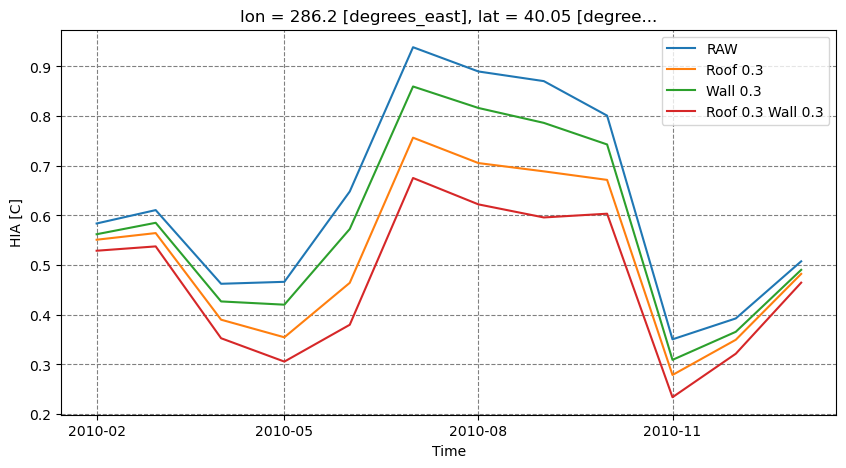

In [3]:
import matplotlib.pyplot as plt

print(now_time())
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#cesm.nc_view()['HIA_U'].plot(ax = ax)
#cesm.nc_view()['HIA_R'].plot(ax = ax)

d0.plot(ax=ax, label="RAW")
d_m_roof.plot(ax=ax, label="Roof 0.3")
d_m_wall.plot(ax=ax, label="Wall 0.3")
d_m_roof_wall.plot(ax=ax, label="Roof 0.3 Wall 0.3")
ax.set_xlabel('Time')

ax.set_ylabel('HIA [C]')
ax.legend()

# Add grid lines
ax.grid(color='gray', linestyle='dashed')

# Set grid lines to align with x-axis ticks
ax.set_axisbelow(True)

plt.show()